# Aviation Risk Analysis Project

Authors: Brian Woo, Evan Rosenbaum

## Overview

This project involves data cleaning, imputation, analysis, and visualization to generate insights for a business stakeholder. The goal is to determine the lowest risk aircraft for a company looking to expand into the aviation industry.

# Business Problem

### General Corporate Stakeholder

#### Diversification into the Aviation Industry

##### Goals

- Our client is looking to diversify their business by venturing into the aviation industry. In doing so, they are looking for new growth opportunities in an industry that has lagged behind other industries in their adoption of technology. 

#### Priorities

##### Safety
- Safety is the foremost concern for our client. They are looking for models with impeccable safety records. Further, they a preference for manufacturers with a proven track record of producing safe and reliable aircraft. 

##### Durability
- Our client is looking for an aircraft that has a long operational life. They want to ensure that their investment pays off and that their aircraft can withstand the wear and tear they put on it. 

##### Lasting Value
- Our client wants to be sure that the aircraft they purchase will not be outdated soon after their purchase. Further, they would prefer for their aircraft to be able to meet the current demands and potential future demands of the industry. 



## Source of Data

The dataset used for this project is from the National Transportation Safety Board (NTSB) and includes aviation accident data from 1962 to 2023. This dataset covers civil aviation accidents and selected incidents in the United States and international waters.

# Understanding the Data Structure

In [1]:
# Import standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from itertools import combinations
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Open the file in read mode and read lines

aviation_df = pd.read_csv('./data_files/AviationData.csv', encoding='latin-1')

state_codes_df = pd.read_csv('./data_files/USState_Codes.csv', encoding='latin-1')

In [3]:
state_codes_df

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
...,...,...
57,Virgin Islands,VI
58,Washington_DC,DC
59,Gulf of mexico,GM
60,Atlantic ocean,AO


In [4]:
# Changing the naming convention of columns
aviation_df.columns = aviation_df.columns.str.lower().str.replace('.', '_')
aviation_df.columns

Index(['event_id', 'investigation_type', 'accident_number', 'event_date',
       'location', 'country', 'latitude', 'longitude', 'airport_code',
       'airport_name', 'injury_severity', 'aircraft_damage',
       'aircraft_category', 'registration_number', 'make', 'model',
       'amateur_built', 'number_of_engines', 'engine_type', 'far_description',
       'schedule', 'purpose_of_flight', 'air_carrier', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured',
       'weather_condition', 'broad_phase_of_flight', 'report_status',
       'publication_date'],
      dtype='object')

In [5]:
# Apply lambda function to remove whitespace from every element in the DataFrame
aviation_df = aviation_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [6]:
# Drops duplicate rows
aviation_df.drop_duplicates(inplace=True)

In [7]:
aviation_df.shape

(88889, 31)

In [8]:
aviation_df

,event_id,investigation_type,accident_number,event_date,location,country,latitude,longitude,airport_code,airport_name,...,purpose_of_flight,air_carrier,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,publication_date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88884,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022
88885,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
88886,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,Personal,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022
88887,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,Personal,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


# Data Types and Missing Values

In [9]:
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_id                88889 non-null  object 
 1   investigation_type      88889 non-null  object 
 2   accident_number         88889 non-null  object 
 3   event_date              88889 non-null  object 
 4   location                88837 non-null  object 
 5   country                 88663 non-null  object 
 6   latitude                34382 non-null  object 
 7   longitude               34373 non-null  object 
 8   airport_code            50249 non-null  object 
 9   airport_name            52790 non-null  object 
 10  injury_severity         87889 non-null  object 
 11  aircraft_damage         85695 non-null  object 
 12  aircraft_category       32287 non-null  object 
 13  registration_number     87572 non-null  object 
 14  make                    88826 non-null

### Missing values

In [10]:
# Percent of missing values in each column
aviation_df.isna().sum() * 100 / len(aviation_df)

event_id                   0.000000
investigation_type         0.000000
accident_number            0.000000
event_date                 0.000000
location                   0.058500
country                    0.254250
latitude                  61.320298
longitude                 61.330423
airport_code              43.469946
airport_name              40.611324
injury_severity            1.124999
aircraft_damage            3.593246
aircraft_category         63.677170
registration_number        1.481623
make                       0.070875
model                      0.103500
amateur_built              0.114750
number_of_engines          6.844491
engine_type                7.961615
far_description           63.974170
schedule                  85.845268
purpose_of_flight          6.965991
air_carrier               81.271023
total_fatal_injuries      12.826109
total_serious_injuries    14.073732
total_minor_injuries      13.424608
total_uninjured            6.650992
weather_condition          5

In [11]:
# Number of unique and missing values
unique_missing_vals = {}
for i in aviation_df.columns:
    unique_missing_vals[i] = len(aviation_df[i].unique())

unique_values= pd.DataFrame(list(unique_missing_vals.items()), columns = ['Column', 'unique_val'])
unique_values["missing_values"] = aviation_df.isna().sum().values
unique_values

,Column,unique_val,missing_values
0,event_id,87951,0
1,investigation_type,2,0
2,accident_number,88863,0
3,event_date,14782,0
4,location,27758,52
5,country,220,226
6,latitude,25593,54507
7,longitude,27157,54516
8,airport_code,10376,38640
9,airport_name,24872,36099


# Descriptive Statistics

In [12]:
aviation_df.describe()

,number_of_engines,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured
count,82805.000000,77488.000000,76379.000000,76956.000000,82977.000000
mean,1.146585,0.647855,0.279881,0.357061,5.325440
std,0.446510,5.485960,1.544084,2.235625,27.913634
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


### Analysis of Statistics

- There are large outlier inside of all of the injury metrics. However, these outliers are important and give us valuable information about the riskiness of the aircraft.

- We should not remove these outliers.


In [13]:
aviation_df.mode().T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
event_id,20001212X19172,20001214X45071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
investigation_type,Accident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident_number,CEN22FA424,CEN22LA149,CEN22LA346,CEN23MA034,DCA22LA135,DCA22LA201,DCA22WA089,DCA22WA130,DCA22WA158,DCA22WA167,...,ERA22LA103,ERA22LA119,ERA22LA364,ERA22LA379,GAA22WA241,WPR22FA309,WPR22LA143,WPR22LA201,WPR23LA041,WPR23LA045
event_date,1982-05-16,1984-06-30,2000-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,"ANCHORAGE, AK",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,332739N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,0112457W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airport_code,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airport_name,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [14]:
def column_info(dataframe, column):
    """
    Provides a view into the row information provided in each column
    -
    Input:
    dataframe : Pandas DataFrame
    columns_list: list 
    -
    Output:
        Prints:
            - A preview of the first 5 values in the column.
            - Value counts of the column.
            - The percentage of missing values in the column.
    """
    preview = dataframe[column].head()
    value_counts = dataframe[column].value_counts()
    percent_missing = dataframe[column].isna().sum() * 100 / len(dataframe)
    
    print("Preview of the first 5 rows in the column:")
    print(preview)
    print("\nValue counts of the column:")
    print(value_counts)
    print("\nPercentage of missing values in the column:")
    print(f"{percent_missing:.2f}%") 

## Normalizing Columns

For the following columns, we are normalizing the casing to account of duplicated entries.

In [15]:
# List of columns
columns_to_lowercase = [
    'investigation_type',
    'injury_severity',
    'aircraft_damage',
    'aircraft_category',
    'make',
    'amateur_built',
    'engine_type',
    'purpose_of_flight',
    'broad_phase_of_flight' 
]

# Convert the columns to lowercase
for column in columns_to_lowercase:
    aviation_df[column] = aviation_df[column].str.lower()

## Filtering the Data 

### location and country

In [16]:
# Preview the row entries for the column
column_info(aviation_df,'location')

Preview of the first 5 rows in the column:
0    MOOSE CREEK, ID
1     BRIDGEPORT, CA
2      Saltville, VA
3         EUREKA, CA
4         Canton, OH
Name: location, dtype: object

Value counts of the column:
ANCHORAGE, AK         434
MIAMI, FL             200
ALBUQUERQUE, NM       196
HOUSTON, TX           193
CHICAGO, IL           184
                     ... 
LOS ANGELES, CHILE      1
Rolla, ND               1
60 E OF BETHEL, AK      1
BOULEVARD, CA           1
JINAN, CHINA            1
Name: location, Length: 27757, dtype: int64

Percentage of missing values in the column:
0.06%


In [17]:
# Check for missing values
aviation_df['location'].isna().sum()

52

In [18]:
# Row entry review

# Copy the DataFrame so no data is lost
aviation_df_copy = aviation_df.copy()

# Fill NaN values with a blank string
aviation_df_copy['location'].fillna('', inplace=True)

# Apply the filter
aviation_df_copy[aviation_df_copy['location'].str.contains('NEAR')]['location']

33        NEAR LAS VEGAS, NV
50       NEAR BAKERSFIEL, CA
75          NEAR BOZEMAN, MT
95          NEAR NUIQSUT, AK
127         NEAR LANSING, MI
                ...         
24104     NEAR TALKEETNA, AK
24268      NEAR COLD BAY, AK
28190       NEAR ILIAMNA, AK
33498      NEAR SKWENTNA, AK
48186      NEAR MUSKEGON, MI
Name: location, Length: 167, dtype: object

In [19]:
# Show if there is a country listed for location values that are NaNs
aviation_df['location'][aviation_df['country'] != 'United States'].value_counts()

ATLANTIC OCEAN                81
SAN JUAN                      53
London, United Kingdom        48
PACIFIC OCEAN                 45
GULF OF MEXICO                30
                              ..
NEWGRANGE, IRELAND             1
Gold Bridge, Canada            1
Tapachula, Chiapas, Mexico     1
Gapyeong, South Korea          1
Las Americas, Las Americas     1
Name: location, Length: 4731, dtype: int64

**Review**

The location column while providing more detail than the country file has some issues.

First is that not every entry has an accurate city location.

Second is that for foreign countries, there are multiple comma delimters indentifying the city. Additionally, the country is listed inside of the location.

**Examples**

- Los Mochis, Sinaloa, Mexico
- Ledbury, Herefordshire, United Kingdom
- Panama City, Panama
- Ji'an City Jiangxi Province, China

**Recommendation**

- Filter the data set so that we only have US flights.
- Create a state category so we can reliably use the consistent information for location.
- Drop the country and location columns. 

**Action**

In [20]:
# Filter for only the rows the country is the United States
aviation_df = aviation_df[aviation_df['country'] == 'United States']

# Drop NaN values from location
aviation_df.dropna(subset=['location'], inplace=True)

# Create a new column 'state' that holds the state information from the location column
aviation_df['state'] = aviation_df['location'].apply(lambda x: x.split(',')[-1].strip())

# Drop the 'location' column
aviation_df.drop(columns=['location'], inplace=True)

# Drop the 'country' column
aviation_df.drop(columns=['country'], inplace=True)

# Merge the csv DataFrames on the 'state' column in aviation_df and 'Abbreviation' column in state_codes_df
aviation_df = pd.merge(aviation_df, state_codes_df, left_on='state', right_on='Abbreviation', how='inner')

# Drop the 'Abbreviation' column as it's no longer needed
aviation_df.drop(columns=['Abbreviation'], inplace=True)

# Drop the 'Abbreviation' column as it's no longer needed
aviation_df.drop(columns=['US_State'], inplace=True)

### investigation_type

In [21]:
# Preview the row entries for the column
column_info(aviation_df,'investigation_type')

Preview of the first 5 rows in the column:
0    accident
1    accident
2    accident
3    accident
4    incident
Name: investigation_type, dtype: object

Value counts of the column:
accident    79826
incident     2327
Name: investigation_type, dtype: int64

Percentage of missing values in the column:
0.00%


**Review**

Events are classified as either being accidents or incidents. 

According to the Code of Federal Regulations, "an accident is defined as an occurrence associated with the operation of an aircraft which takes place between the time any person boards the aircraft with the intention of flight and all such persons have disembarked, and in which any person suffers death or serious injury, or in which the aircraft receives substantial damage. For purposes of this part, the definition of “aircraft accident” includes “unmanned aircraft accident,” as defined herein."

An incident is defined as "an occurrence other than an accident, associated with the operation of an aircraft, which affects or could affect the safety of operations."

https://www.ecfr.gov/current/title-49/subtitle-B/chapter-VIII/part-830/subpart-A/section-830.2

**Recommendation**

Narrow our search to only include records that are labeled as accident. 
- This would result in about 5% of the total data being dropped.

**Action**

In [22]:
# Filter the event_id column for only accidents
aviation_df = aviation_df[aviation_df['investigation_type'] != 'incident']

## Analysis for Columns to Drop

### Columns with Unique Identifiers

- event_id
    - The event_id serves as a unqiue indentifier for each row entry. These are for reference to search the event on the NTSB aviation accident database.
- accident_number
    - The accident_number serves as a unqiue indentifier for each row entry. These are for reference to search the event on the NTSB aviation accident database.
- registration_number
    - It is unclear why there is missing values or duplicated values inside of this column as one would assume that every aircrafts registration number would be unique.
    - No documentation on this column could be located to provide further information.

### Columns with missing values above 50%

**Overview**

These columns contain too much missing data. Additionally, they are not pertinent to the business question. 

**Specific Column Information**

- latitude
- longitude
- far_description
    - The column contains references to the Federal Aviation Regulations (FARs) or similar regulatory categories. The FARs are a set of rules prescribed by the Federal Aviation Administration (FAA) governing all aviation activities in the United States.
    - The values are not normalized and contain duplicates.
     - Examples:
        - Part 91: General Aviation
            - Covers general operating and flight rules for all aircraft not governed by other specific parts (e.g., private pilots, corporate flights, etc.).
        - PUBU: Public Use
             - Refers to aircraft operated by government agencies or other public entities for official purposes.
        - https://www.faa.gov/hazmat/air_carriers/operations
        - https://www.ecfr.gov/current/title-14
- schedule
    - No documentation on this column could be located to provide further information.

### Columns with insignficant data in reference to business question

**Overview**

These columns while providing interesting information do not provide pertinent information in relation to the busines question. 

- airport_code
- airport_name
- air_carrier
- publication_date

### Action to Drop Columns

In [23]:
# drop the columns that are not useful for analysis
columns_to_drop = [
    'event_id',
    'accident_number',
    'latitude',
    'longitude',
    'airport_code',
    'airport_name',
    'registration_number',
    'far_description',
    'schedule',
    'air_carrier',
    'publication_date',
]

aviation_df.drop(columns=columns_to_drop, inplace=True)

## Analysis for Dropping Row NaN's

### make and model

**Overview**

We want to ensure there is a make and model for every row element. If there is no make and mode, we cannot give a recommendation to the business. 

**Action**

In [24]:
# Drop missing values inside of the 'make' column
aviation_df.dropna(subset=['make', 'model'], inplace=True)

## Analysis for Columns to Replace NaN's

### Columns with no pre-existing unknown category

For each of these columns, there are no pre-existing unknown or other categories. 

As such, we are filling the NaN values with an 'unknown' string. 

In [25]:
columns_to_replace_with_unknown = [
    'purpose_of_flight',
    'report_status',
    'aircraft_damage',
    'aircraft_category',
    'model',
    'amateur_built'
]

aviation_df[columns_to_replace_with_unknown] = aviation_df[columns_to_replace_with_unknown].fillna('unknown')

### Columns with pre-existing unknown category (UNK, Unknown, Other)

In [26]:
# find Columns with pre-existing unknown category (UNK, Unknown, Other, None) and replace them with 'unknown'
columns_to_replace_with_unknown = [
    'investigation_type',
    'event_date',
    'injury_severity', 
    'aircraft_damage',
    'aircraft_category',
    'make',
    'model',
    'amateur_built',
    'engine_type',
    'purpose_of_flight',
    'weather_condition',
    'broad_phase_of_flight',
    'report_status'
]

replace_values = ['unk', 'unknown', 'other', 'none', 'unavailable', np.nan]

aviation_df[columns_to_replace_with_unknown] = aviation_df[columns_to_replace_with_unknown].applymap(
    lambda x: 'unknown' if isinstance(x, str) and x.lower() in replace_values or pd.isna(x) else x)


## Imputing Numerical Column Values

### total_fatal_injuries, total_serious_injuries, total_minor_injuries and total_uninjured

**Overview**

The total_fatal_injuries, total_serious_injuries, total_minor_injuries, and total_uninjured columns were replaced with the median values of the column.

In [27]:
injury_columns = [
    'total_fatal_injuries', 
    'total_serious_injuries', 
    'total_minor_injuries', 
    'total_uninjured'
]

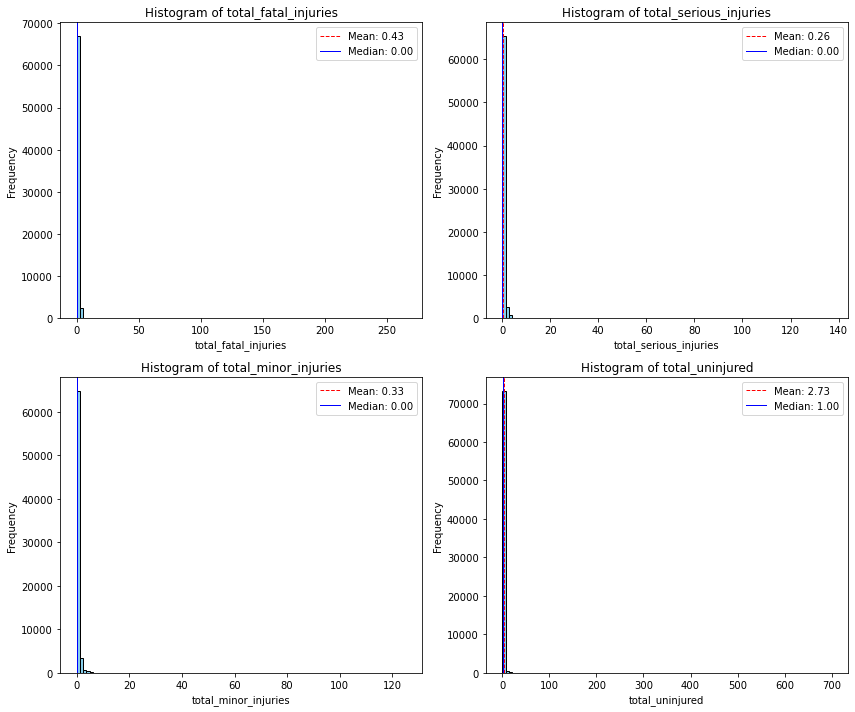

In [28]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each column and plot a histogram
for i, column in enumerate(injury_columns):
    # Drop NaN values before plotting
    data = aviation_df[column].dropna()
    
    # Plot histogram
    axes[i].hist(data, bins=100, color='skyblue', edgecolor='black')
    
    # Calculate mean and median
    mean_val = data.mean()
    median_val = data.median()
    
    # Draw vertical lines for mean and median
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='blue', linestyle='-', linewidth=1, label=f'Median: {median_val:.2f}')
    
    # Set title for each subplot
    axes[i].set_title(f'Histogram of {column}')
    
    # Set labels for x and y axes
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
    # Add legend
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


**Overview**

Given the positve skew of each column, we will impute the missing values with the median. 

**Action**

In [29]:
# Imputing the missing values with the median
aviation_df[injury_columns] = aviation_df[injury_columns].apply(lambda x: x.fillna(x.median()))

In [30]:
# Creating 'total_injuries' column
aviation_df['total_injuries'] = aviation_df[
    ['total_fatal_injuries', 
     'total_serious_injuries', 
     'total_minor_injuries'
    ]
].sum(axis=1)

### number_of_engines

**Overview**

The number_of_engines had to be done differently because, it would be better to be true to the data, because it is impossible to correlate the number of engines in a plane.

Big planes could have 1 engine, while another big plane of the same sizes could have 2 or more engines

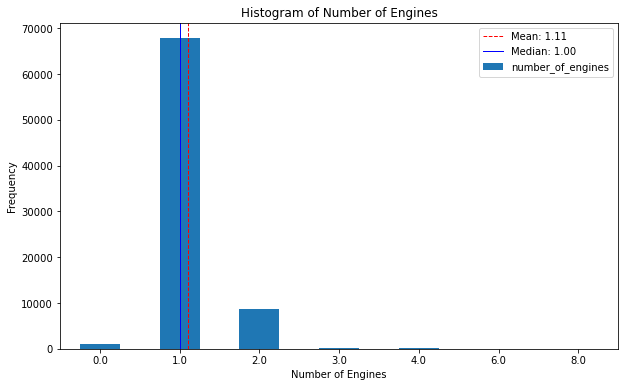

In [31]:
# Get values for histogram
value_counts = aviation_df['number_of_engines'].value_counts().sort_index()

# Calculate mean and median
mean_num_engines = aviation_df['number_of_engines'].mean()
median_num_engines = aviation_df['number_of_engines'].median()

# Plot a histogram of the value counts
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Number of Engines')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Engines')
plt.xticks(rotation=0)

# Add vertical lines for mean and median
plt.axvline(x=mean_num_engines, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_num_engines:.2f}')
plt.axvline(x=median_num_engines, color='blue', linestyle='-', linewidth=1, label=f'Median: {median_num_engines:.2f}')

# Add legend
plt.legend()

# Show the plot
plt.show()

**Recommendation**

Unlike the injury columns, this column should be treated as a categorical column since the number of wheels describing the aircraft. 

As such, we will convert the column type to object and fill the missing values with an unknown category.

**Action**

In [32]:
aviation_df['number_of_engines'] = aviation_df['number_of_engines'].fillna('unknown')

## Adding New Columns and Cleaning Individual Columns

### New Columns

In [33]:
# Adding 'total_injuries' column
aviation_df['total_injuries'] = (
    aviation_df['total_fatal_injuries'] +
    aviation_df['total_serious_injuries'] +
    aviation_df['total_minor_injuries']
)

# Adding 'year', 'month', and 'day' columns
aviation_df['event_date'] = pd.to_datetime(aviation_df['event_date'])
aviation_df['year'] = aviation_df['event_date'].dt.year
aviation_df['month'] = aviation_df['event_date'].dt.month
aviation_df['day'] = aviation_df['event_date'].dt.day

aviation_df.drop(columns=['event_date'], inplace=True)

### Cleaning Individual Columns

#### injury_severity

In [34]:
# Removing the count that follows the description of the injury in the 'injury_severity column'
aviation_df['injury_severity'] = aviation_df['injury_severity'].apply(lambda x: x.split('(')[0])

##### report_status

In [35]:
column_info(aviation_df, 'report_status')

Preview of the first 5 rows in the column:
0    Probable Cause
1    Probable Cause
2    Probable Cause
3    Probable Cause
5    Probable Cause
Name: report_status, dtype: object

Value counts of the column:
Probable Cause                                                                                                                                                           59271
unknown                                                                                                                                                                   2550
Factual                                                                                                                                                                    139
The pilot's failure to maintain directional control during the landing roll.                                                                                                64
The pilots failure to maintain directional control during the landing roll.                 

**Review:**

After reviewing the report status for accidents there is a large number of records the mention the pilot as the source of the accident. 

However, the most common entries in the column are:

- Probable Cause : 61754
- Foreign : 1999
- Factual : 167

**Recommendation:**

We make a column identifying explicit pilot error by searching for the keyword of pilot. The keyword while general is reflective of pilot error given that each row represents an accident and that when a description is given, it is telling us about the error that occurred that caused the accident. 

The new column will be a boolean value. 

Fill the NaN values with 'unknown'

**Examples:**

- "The pilot’s decision to perform a takeoff from a perpendicular taxiway rather than the airport runway, which led to the airplane striking trees at the end of the departure path."

- "The pilot’s failure to maintain airplane control during the landing roll on a snow-covered runway surface."

- "The pilot’s failure to retract the flaps during a go-around from a bounced landing, which resulted in a collision with trees then terrain."

**Action**

In [36]:
# Create a new column 'human_error' with True and False labels based on 'investigation_type'
aviation_df['human_error'] = aviation_df['investigation_type'].str.contains('pilot', case=False) | aviation_df['investigation_type'].str.contains('instructor', case=False)

#### make

In [37]:
# Create a dictionary to store the mapping of individual make names to origin names
make_origin_mapping = {}

# Iterate over each make in aviation_df to extract the origin name
for make in aviation_df['make'].unique():
    origin_make = make.split()[0]  # Get the origin make ('mcdonnell douglas helicopter' from 'mcdonnell')
    make_origin_mapping[make] = origin_make
    
aviation_df['make'] = aviation_df['make'].map(make_origin_mapping)

#### Commerical Jet Cleaning

In [38]:
def create_comparison_bar_chart(dataframe, categorical_col, numerical_col, measure, sort_boolean, num_of_values_shown):
    # Calculate numerical measure for each categorical column
    num_by_cat = dataframe.groupby(categorical_col)[numerical_col].agg(measure)
    
    #Sort the data
    num_by_cat = num_by_cat.sort_values(ascending=sort_boolean).head(num_of_values_shown)
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    num_by_cat.plot(kind='bar', color='skyblue')
    plt.title(f'{numerical_col} by {categorical_col}')
    plt.xlabel(f'{categorical_col}')
    plt.ylabel(f'{numerical_col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

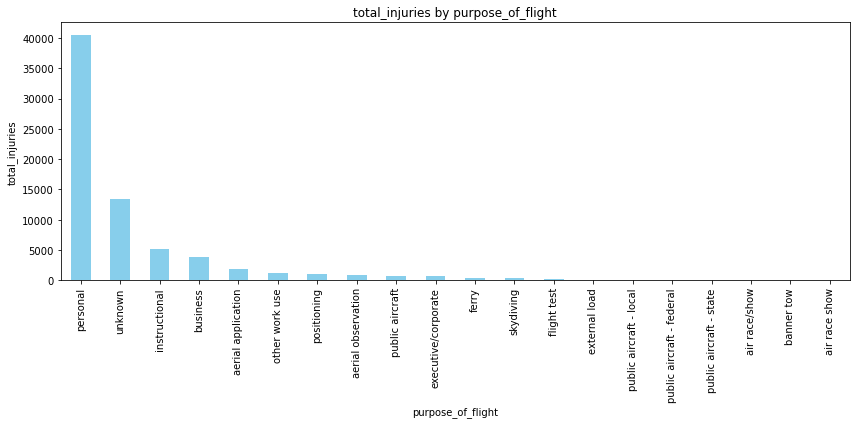

In [39]:
create_comparison_bar_chart(aviation_df, 'purpose_of_flight', 'total_injuries', 'sum', False, 20)

Our stakeholder wants to see whether to get into the Commercial or Private airline industry based primarily on the safety of the aircraft. 

At present, the data set does not have a classification for Commercial Flights inside of the 'purpose_of_flight' column. 

Commercial Travel Planes primarily use Turbo Fan engines however the data set includes duplicate plane models inside of the Turbo Jet engine classification. To account for this, we are going to include both engine types and manually review the models to ensure only commercial planes are included in the analysis. 

In [40]:
# Filter the DataFrame for specific engine types and select relevant columns
filtered_df = aviation_df[
    aviation_df['engine_type'].isin(['turbo fan', 'turbo jet'])
][['make', 'model', 'engine_type', 'purpose_of_flight']]

# Filter the DataFrame to exclude erroneous plane addition
final_airbus_df = filtered_df[(filtered_df['model'] != 'F4-6')]

# Count occurrences and reset the index
value_counts_df = final_airbus_df.value_counts().reset_index()

# Filter for instances containing 'airbus'
airbus_commerical_planes = value_counts_df[value_counts_df['make'].str.contains('airbus', case=False)]

# Get unique models
unique_airbus_commerical_planes = airbus_commerical_planes['model'].unique()

##### Airbus

In [41]:
airbus_replace_dict = {}

for plane in unique_airbus_commerical_planes:
    if not plane[0].isalpha(): 
        # If the first character is not a letter, prefix the plane name with 'A' and take the first three characters of the original name
        airbus_replace_dict[plane] = 'A' + plane[:3]
    elif plane[1] == '-': 
        # If the second character is a hyphen, remove the hyphen and take the first four characters of the modified name
        airbus_replace_dict[plane] = plane.replace('-', '')[:4]
    else:
        # Take the first four characters of the plane name
        airbus_replace_dict[plane] = plane[:4]

In [42]:
# Filter the DataFrame to exclude erroneous plane addition
final_airbus_df = filtered_df[(filtered_df['model'] != 'DC-10')]

# Count occurrences and reset the index
value_counts_df = filtered_df.value_counts().reset_index()

# Filter for instances containing 'boeing'
unique_boeing_commercial_planes = value_counts_df[value_counts_df['make'].str.contains('boeing', case=False)]

# Get unique models
unique_boeing_commercial_planes = unique_boeing_commercial_planes['model'].unique()

##### Boeing

In [43]:
boeing_replace_dict = {}
for plane in unique_boeing_commercial_planes:
    if plane[1] == '-':
        # If the plane starts with 'B' and contains '-', like 'B737-300', take the part after 'B' and before the '-'
        boeing_replace_dict[plane] = plane.replace('-', '')[1:4]
    elif "BOEING" in plane:
        # If the plane contains 'BOEING', like 'BOEING 777-236',remove 'BOEING', strip leading/trailing whitespace,
        # and extract the first three digits from the remaining string
        boeing_replace_dict[plane] = plane.replace('BOEING', '')[1:4]
    elif "MD" in plane or "DC" in plane:
        # If the plane contains 'MD' or 'DC', like 'MD-11' or 'DC-10', take the first five characters of the plane
        boeing_replace_dict[plane] = plane[:5]
    elif plane[0].isalpha():
        # If the plane starts with an alpha character, take characters from index 1 to 4
        boeing_replace_dict[plane] = plane[1:4]
    else:
        # Take the first three characters
        boeing_replace_dict[plane] = plane[:3]

##### McDonell

In [44]:
# find the mcdonnell douglas planes
filter_mcdonnell_planes = aviation_df[
    (aviation_df['engine_type'].isin(['turbo fan', 'turbo jet'])) & 
    (aviation_df['purpose_of_flight'] == 'unknown') &
    (aviation_df['make'] == 'mcdonnell')
]['model'].unique()

# remove the rows with model 'RF-4C' and F/A-18C in filter_mcdonnell_planes
models_to_remove = ['RF-4C', 'F/A-18C']
unique_mcdonnell_commerical_planes = [model for model in filter_mcdonnell_planes if model not in models_to_remove]

In [45]:
mcdonnell_replace_dict = {}

for plane in unique_mcdonnell_commerical_planes:
    # Use regex to split the model
    parts = re.split(r'[- ]', plane)
    
    if len(parts) > 1:
        # Extract only numeric part from the second segment
        numeric_part = ''.join(filter(str.isdigit, parts[1]))
        if numeric_part:
            if plane == 'DC10-30F':
                mcdonnell_replace_dict[plane] = 'DC10'
            elif plane == 'DC8-63F':
                mcdonnell_replace_dict[plane] = 'DC8'
            else:
                mcdonnell_replace_dict[plane] = parts[0] + numeric_part
        else:
            mcdonnell_replace_dict[plane] = parts[0]
    else:
        
        mcdonnell_replace_dict[plane] = plane.replace(' ', '')

##### Embraer

In [46]:
# find the embraer planes
unique_embraer_commerical_planes = aviation_df[
    (aviation_df['engine_type'].isin(['turbo fan', 'turbo jet'])) & 
    (aviation_df['purpose_of_flight'] == 'unknown') &
    (aviation_df['make'] == 'embraer')
]['model'].unique()

In [47]:
# only get the first 6 letters (erj) and numbers in filter_embraer_planes
embraer_replace_dict = {}
for plane in unique_embraer_commerical_planes:
    embraer_replace_dict[plane] = 'ERJ' + ''.join(filter(str.isdigit, plane[:7]))

##### Fokker

In [48]:
# find the fokker planes
unique_fokker_commercial_planes = aviation_df[
    (aviation_df['engine_type'].isin(['turbo fan', 'turbo jet'])) & 
    (aviation_df['purpose_of_flight'] == 'unknown') &
    (aviation_df['make'] == 'fokker')
]['model'].unique()

In [49]:
# only f and get the next full number
fokker_replace_dict = {}
for plane in unique_fokker_commercial_planes:
    # print(plane)
    hypen_splitter = plane.split('-')
    space_splitter = plane.split(' ')
    if not plane[0].isalpha():
        fokker_replace_dict[plane] = 'F' + ''.join(filter(str.isdigit, plane[:2]))
    elif plane[2] == '-':
        value = hypen_splitter[0] + hypen_splitter[1]
        fokker_replace_dict[plane] = value.replace('K', '')
    elif space_splitter[0] == 'F28':
        fokker_replace_dict[plane] = 'F28'
    elif plane[1] == '-':
        fokker_replace_dict[plane] = space_splitter[0].replace('-', '')
    elif plane[1] == '.':
        fokker_replace_dict[plane] = space_splitter[0].replace('.', '')
    else:
        fokker_replace_dict[plane] = plane

##### Lockheed

In [50]:
# find the lockheed planes
unique_lockheed_commercial_planes = aviation_df[
    (aviation_df['engine_type'].isin(['turbo fan', 'turbo jet'])) & 
    (aviation_df['purpose_of_flight'] == 'unknown') &
    (aviation_df['make'] == 'lockheed')
]['model'].unique()

In [51]:
lockheed_replace_dict = {}
for plane in unique_lockheed_commercial_planes:
    hypen_splitter = plane.split('-')
    if plane[1] == '-':
        lockheed_replace_dict[plane] = hypen_splitter[0] + hypen_splitter[1]
    else:
        lockheed_replace_dict[plane] = hypen_splitter[0]

##### Illyushin

In [52]:
#find the illyushin planes
unique_ilyushin_commercial_plane = aviation_df[
    (aviation_df['engine_type'].isin(['turbo fan', 'turbo jet'])) & 
    (aviation_df['purpose_of_flight'] == 'unknown') &
    (aviation_df['make'] == 'ilyushin')
]['model'].unique()

In [53]:
ilyushin_replace_dict = {}
unique_ilyushin_commercial_plane[0].replace('-', '')
ilyushin_replace_dict[unique_ilyushin_commercial_plane[0]] = unique_ilyushin_commercial_plane[0].replace('-', '')

##### Apply replacement dictionaries

In [54]:
list_of_replacement_dictionaries = [
    airbus_replace_dict,
    boeing_replace_dict,
    mcdonnell_replace_dict,
    embraer_replace_dict,
    fokker_replace_dict,
    lockheed_replace_dict,
    ilyushin_replace_dict
]

# Apply the replacements
for replace_dict in list_of_replacement_dictionaries:
    aviation_df['model'] = aviation_df['model'].replace(replace_dict)

##### Fill 'purpose_of_flight' with commercial flight classification

In [55]:
makes_to_include = [
    'boeing', 
    'airbus', 
    'embraer', 
    'mcdonnell', 
    'lockheed', 
    'douglas', 
    'fokker', 
    'ilyushin'
]

aviation_df.loc[
    (
        ((aviation_df['engine_type'] == 'turbo fan') | (aviation_df['engine_type'] == 'turbo jet')) &
        (aviation_df['purpose_of_flight'] == 'unknown') &
        ((aviation_df['amateur_built'] == 'no') | (aviation_df['amateur_built'] == 'unknown')) &
        (aviation_df['make'].isin(makes_to_include))
    ),
    'purpose_of_flight'
] = 'commercial flight'

#### Make and model 

In [56]:
# Create 'make_model' column
aviation_df['make_model'] = aviation_df['make'] + ' ' + aviation_df['model']

## Cleaned Dataset

In [57]:
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79786 entries, 0 to 82152
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   investigation_type      79786 non-null  object 
 1   injury_severity         79786 non-null  object 
 2   aircraft_damage         79786 non-null  object 
 3   aircraft_category       79786 non-null  object 
 4   make                    79786 non-null  object 
 5   model                   79786 non-null  object 
 6   amateur_built           79786 non-null  object 
 7   number_of_engines       79786 non-null  object 
 8   engine_type             79786 non-null  object 
 9   purpose_of_flight       79786 non-null  object 
 10  total_fatal_injuries    79786 non-null  float64
 11  total_serious_injuries  79786 non-null  float64
 12  total_minor_injuries    79786 non-null  float64
 13  total_uninjured         79786 non-null  float64
 14  weather_condition       79786 non-null

# Business Question 1: Which area of the avaiation industry should they get into?¶

With our stakeholders first priority being safety, we want to determine which portion of the industry either commerical flights or private flights is safer. 

To measure safety, we are using the total number of injuries (fatal, serious, and minor).

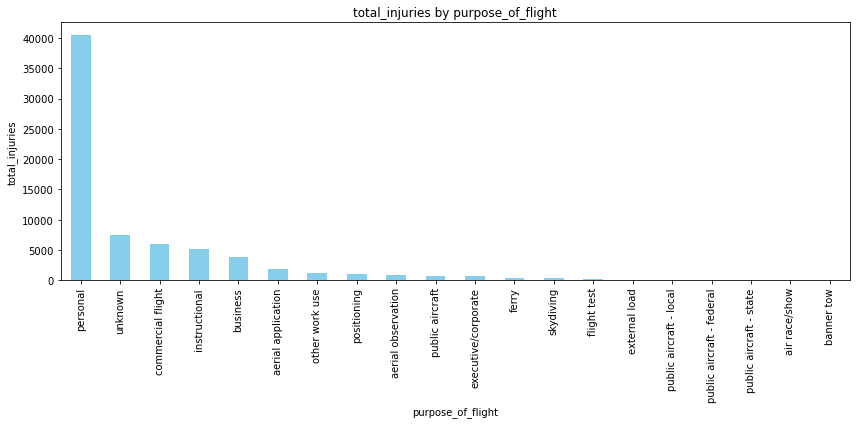

In [58]:
create_comparison_bar_chart(aviation_df, 'purpose_of_flight', 'total_injuries', 'sum', False, 20)

**Review**

Overwhelmingly, the largest cause of injury when onboard an aircraft is while flying for personal reasons. This could be due to a multitude of reasons, cheif among them is flight hours.

Given the data, the hourly requirement should be increased to limit the injuries caused by personal flights. 

"A person applying for a private pilot certificate in airplanes, helicopters, and gyro-planes must log at least 40 hours of flight time, of which at least 20 hours are flight training from an authorized instructor and 10 hours of solo flight training in the appropriate areas of operation; three hours of cross country; three hours at night, three hours of instrument time; and other requirements specific to the category and class rating sought.

Private pilots in gliders and lighter-than-air aircraft must have logged from an authorized instructor a similar number of hours and/ or training flights, which include both cross country and solo according to category and class rating sought. Though the regulations require a minimum of 40 hours flight time, in the U. S. the average number of hours for persons without a hearing impairment completing the private pilot certification requirements is approximately 75 hours."

Importantly, commercial flights are slightly less risky than business flights. If we include executive/corporate flight purposes in with business flights, we see that commercial flights are the safer option between private or commercial flights. 

- https://www.faa.gov/faq/what-are-hourly-requirements-becoming-pilot

**Action**

Given that commercial flights have a higher degree of safety (fewer total injuries) than business/executive/corporate flights we suggest to our stakeholder that pursue commercial flights rather than private flights. 

As such, we will trim our data set to view only commercial flights so that we can provide targeted insights. 

In [59]:
commercial_flights_df = aviation_df[(aviation_df['purpose_of_flight'] == 'commercial flight')]

In [60]:
commercial_flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 321 to 82133
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   investigation_type      858 non-null    object 
 1   injury_severity         858 non-null    object 
 2   aircraft_damage         858 non-null    object 
 3   aircraft_category       858 non-null    object 
 4   make                    858 non-null    object 
 5   model                   858 non-null    object 
 6   amateur_built           858 non-null    object 
 7   number_of_engines       858 non-null    object 
 8   engine_type             858 non-null    object 
 9   purpose_of_flight       858 non-null    object 
 10  total_fatal_injuries    858 non-null    float64
 11  total_serious_injuries  858 non-null    float64
 12  total_minor_injuries    858 non-null    float64
 13  total_uninjured         858 non-null    float64
 14  weather_condition       858 non-null  

# Outliers Detection

## Numerical Columns

In [61]:
def find_outliers_iqr(dataframe, column):
    """
    Find the outliers in the column using the IQR method
    -
    Input: 
        dataframe: Pandas DataFrame
        column: str
    -
    Output:
        Prints:
            - The number of outliers in the column.
            - The percentage of outliers in the column.
    """
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    percent_outliers = len(outliers) * 100 / len(dataframe)
    
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {percent_outliers:.2f}%")

In [62]:
numerical_columns = [
    'total_fatal_injuries',
    'total_serious_injuries',
    'total_minor_injuries',
    'total_uninjured',
    'total_injuries'
]

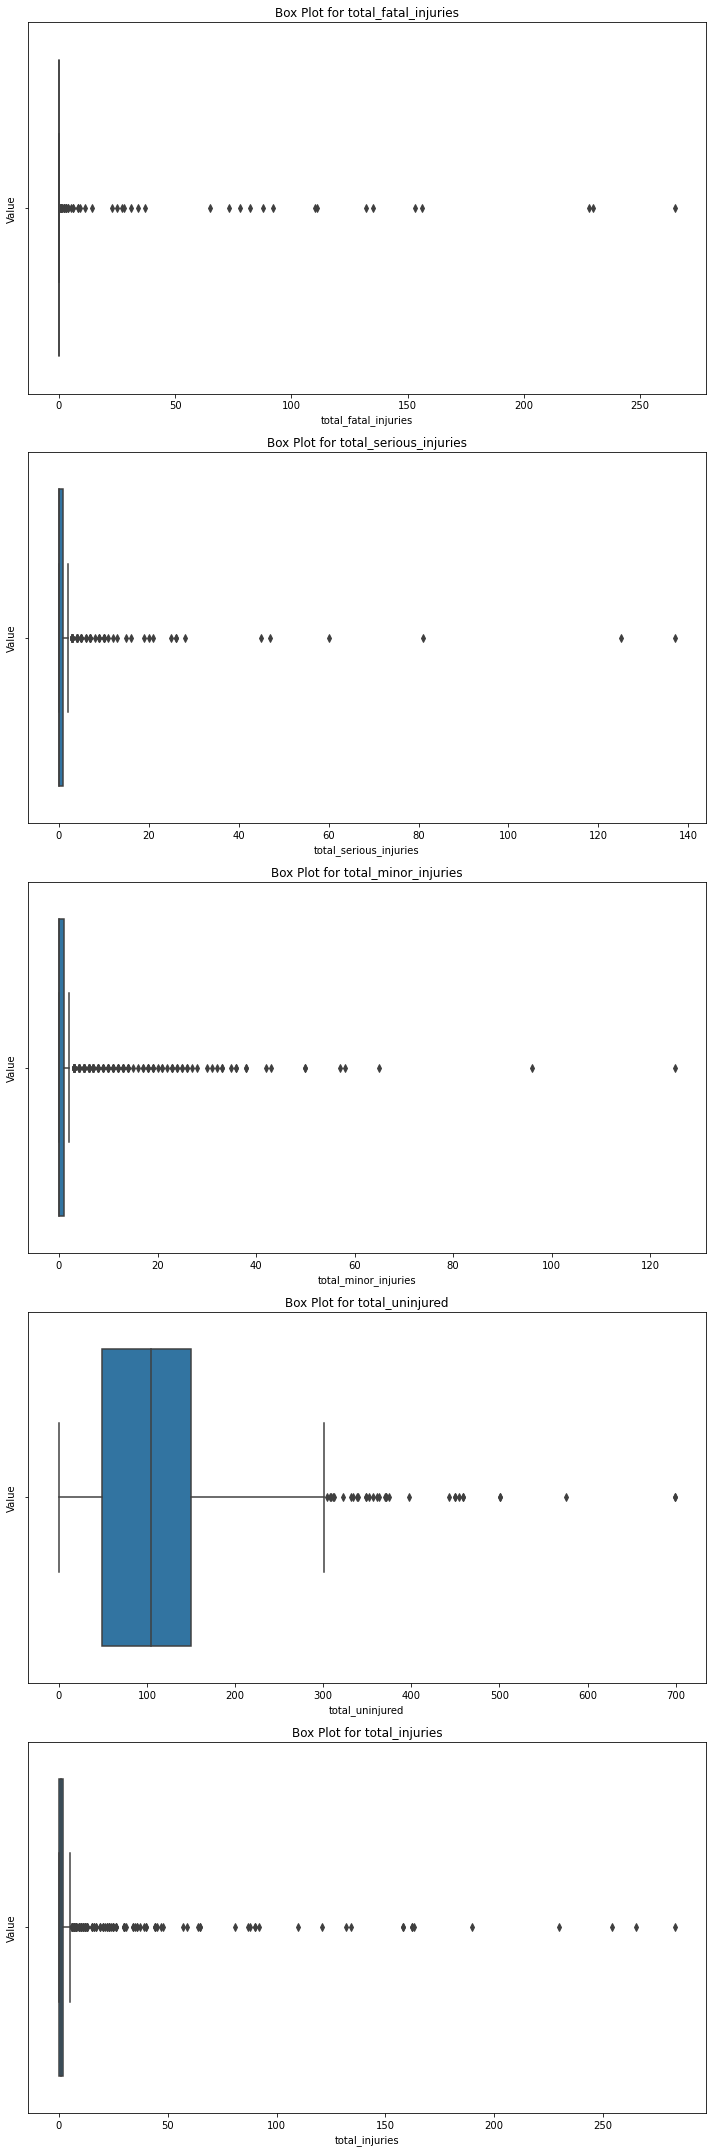

In [63]:
# Create subplots for box plots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 6 * len(numerical_columns)))

# Plot each numerical column in a separate subplot
for ax, column in zip(axes, numerical_columns):
    sns.boxplot(data=commercial_flights_df, x=column, ax=ax)
    ax.set_title(f'Box Plot for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [64]:
# Printing out the number/percentage of outliers

for column in numerical_columns:
    print('\n', column)
    find_outliers_iqr(commercial_flights_df, column)


 total_fatal_injuries
Number of outliers: 69
Percentage of outliers: 8.04%

 total_serious_injuries
Number of outliers: 65
Percentage of outliers: 7.58%

 total_minor_injuries
Number of outliers: 138
Percentage of outliers: 16.08%

 total_uninjured
Number of outliers: 32
Percentage of outliers: 3.73%

 total_injuries
Number of outliers: 136
Percentage of outliers: 15.85%


### Explaination of Data

The box and whisker plots above show a line rather than a rectangle for the IQR because the range of the IQR is between 0 and 1. On the graph, when comparing the IQR to the outliers that exist, the range of the outliers far outsizes the range of the IQR.

**Handling Outliers**

Even though the outliers skew the columns, we will keep all of the outliers that are in all of the numerical columns because the outliers are relevant data points that provide useful information for each column. 

# Correlation Analysis

## Numerical Columns Correlation

In [65]:
commercial_flights_df.corr()

,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,total_injuries,year,month,day,human_error
total_fatal_injuries,1.000000,0.163968,0.107538,-0.161408,0.839810,-0.106748,0.025406,-0.045818,NaN
total_serious_injuries,0.163968,1.000000,0.428098,-0.055471,0.577230,0.008478,-0.034270,-0.027475,NaN
total_minor_injuries,0.107538,0.428098,1.000000,0.046848,0.555760,-0.182470,-0.012905,-0.038954,NaN
total_uninjured,-0.161408,-0.055471,0.046848,1.000000,-0.122396,0.109442,-0.021455,-0.033128,NaN
total_injuries,0.839810,0.577230,0.555760,-0.122396,1.000000,-0.140412,0.004173,-0.056291,NaN
year,-0.106748,0.008478,-0.182470,0.109442,-0.140412,1.000000,-0.001001,0.008449,NaN
month,0.025406,-0.034270,-0.012905,-0.021455,0.004173,-0.001001,1.000000,0.027645,NaN
day,-0.045818,-0.027475,-0.038954,-0.033128,-0.056291,0.008449,0.027645,1.000000,NaN
human_error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


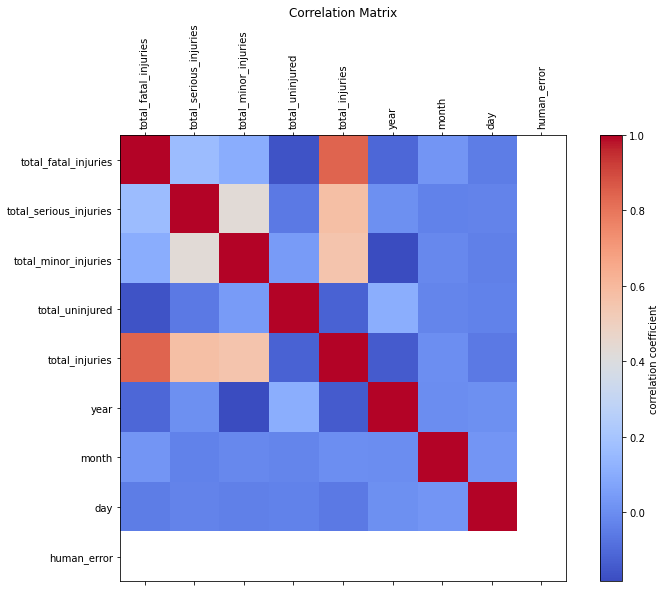

In [66]:
# use correlation matrices and scatter plots to understand relationships between numerical variables
correlation_matrix = commercial_flights_df.corr()

plt.figure(figsize=(12, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar(label='correlation coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')

plt.show()

In [67]:
def scatter_plot(dataframe, columns):
    """
    Create scatter plots for numerical columns.
    -
    Input:
        dataframe: Pandas DataFrame
        columns: list of column names (strings)
    -
    Output:
        Displays scatter plots for each column pair
    """
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            plt.figure(figsize=(12, 8))
            plt.scatter(dataframe[columns[i]], dataframe[columns[j]], alpha=0.5)
            plt.xlabel(columns[i])
            plt.ylabel(columns[j])
            plt.title(f'{columns[i]} vs {columns[j]}')
            plt.grid(True)
            plt.show()

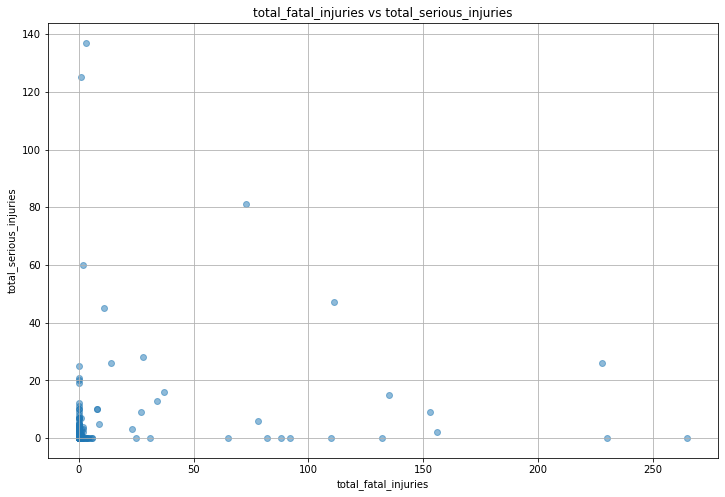

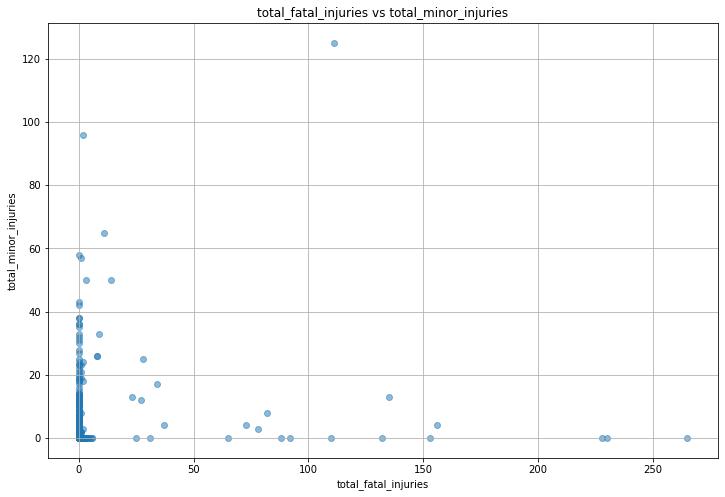

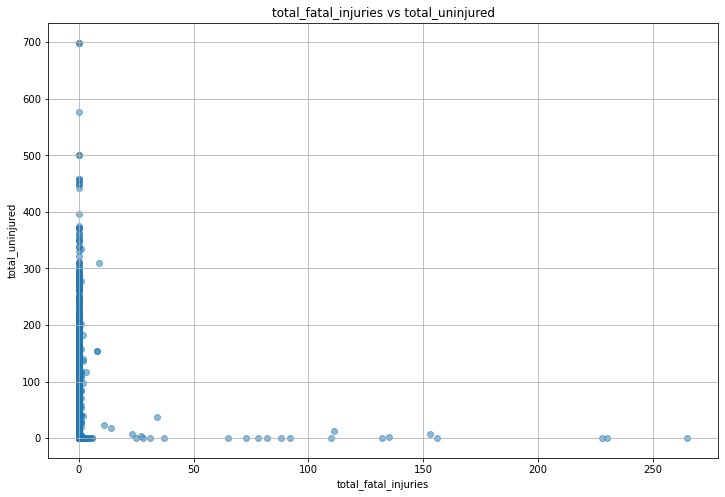

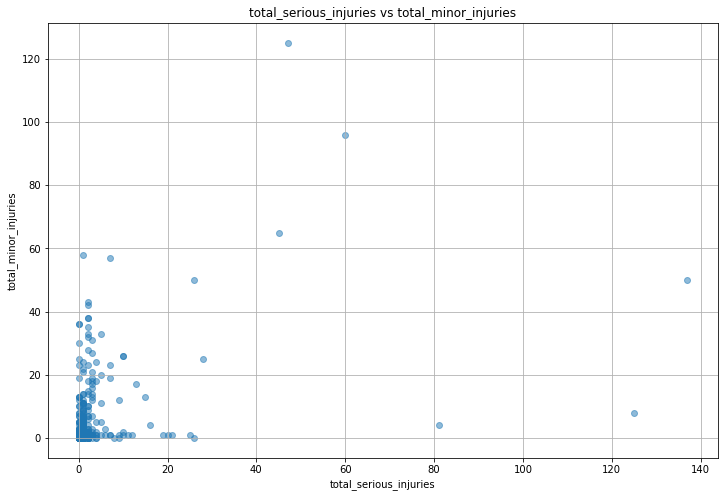

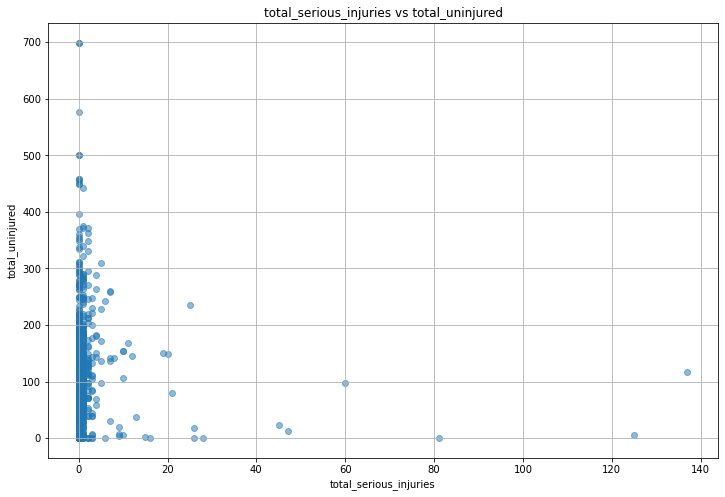

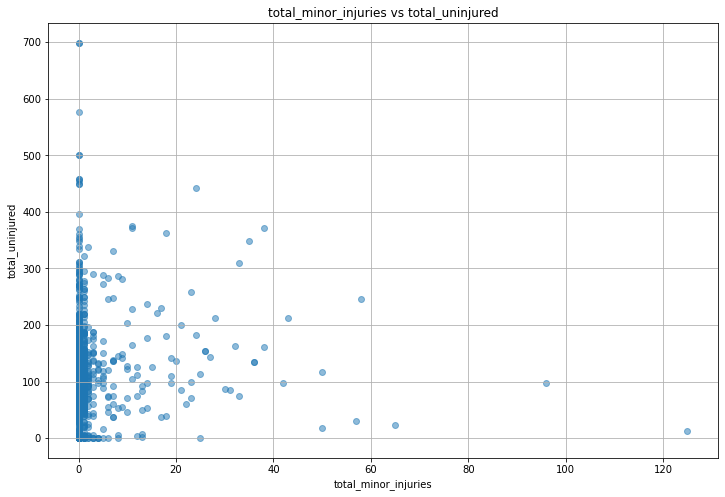

In [68]:
# List of numerical columns to compare
numerical_columns = ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']

# Call the function with the dataframe and the list of columns
scatter_plot(commercial_flights_df, numerical_columns)

## Categorical Columns Correlation

In [69]:
def chi_squared_test(dataframe, column1, column2):
    """
    Perform a chi-squared test for independence between two categorical variables.
    
    Input:
        dataframe: Pandas DataFrame
        column1: str
        column2: str
        
    Output:
        Returns chi-squared test statistic, p-value, and degrees of freedom.
    """
    contingency_table = pd.crosstab(dataframe[column1], dataframe[column2])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    return chi2, p, dof

In [70]:
def find_correlating_columns(dataframe, columns_to_compare, alpha=0.01):
    """
    Find the most correlating columns using the chi-squared test.
    
    Input:
        dataframe: Pandas DataFrame
        columns_to_compare: list of str, specific columns to include in the comparison
        alpha: float, significance level
        
    Output:
        DataFrame with pairs of columns and their chi-squared test results.
    """
    # Replace placeholders with NaNs
    dataframe.replace(['unknown', 'N/A', 'na', '', ' '], pd.NA, inplace=True)
    
    # Drop rows with NaNs in the specified columns
    dataframe = dataframe[columns_to_compare].dropna()
    
    # Generate pairs of specified columns
    column_pairs = list(combinations(columns_to_compare, 2))
    
    # Perform chi-squared test for each pair
    results = []
    for col1, col2 in column_pairs:
        chi2, p, dof = chi_squared_test(dataframe, col1, col2)
        # Append results if the p-value is less than or equal to the alpha level
        if p <= alpha:
            results.append((col1, col2, chi2, p, dof))
    
    # Create a DataFrame to store results
    results_df = pd.DataFrame(results, columns=['Column 1', 'Column 2', 'Chi-squared', 'P-value', 'Degrees of Freedom'])
    
    # Sort by P-value first and then by Chi-squared test statistic
    results_df.sort_values(by=['P-value', 'Chi-squared'], ascending=[True, False], inplace=True)
    
    return results_df

In [71]:
columns_to_compare = ['total_injuries', 
                      'aircraft_damage',
                      'weather_condition', 
                      'broad_phase_of_flight', 
                      'make_model', 
                      'state', 
                      'year',
                      'month'
]
chi_square_df = commercial_flights_df[columns_to_compare].copy()

correlating_columns = find_correlating_columns(chi_square_df, columns_to_compare, alpha=0.01)
correlating_columns.head(10)

,Column 1,Column 2,Chi-squared,P-value,Degrees of Freedom
3,total_injuries,state,3008.621264,4.467451e-35,2107
0,total_injuries,aircraft_damage,309.073922,1.058869e-23,98
2,total_injuries,broad_phase_of_flight,684.946561,2.927402e-18,392
6,aircraft_damage,broad_phase_of_flight,83.402215,4.031671e-11,16
12,state,year,1342.901158,3.663065e-06,1118
5,aircraft_damage,weather_condition,19.915267,4.736470e-05,2
4,total_injuries,year,1468.623532,1.129348e-04,1274
1,total_injuries,weather_condition,93.844238,1.215893e-04,49
7,weather_condition,state,82.931007,2.448064e-04,43
10,broad_phase_of_flight,year,279.670011,6.686731e-04,208


## Results
Above are the 10 most relevant data to compare based on p-value and the chi-squared tests.
- The p-value represents the probability of observing the test results.
    - Ranges from 0-1
    - Closer to 0 indicates a strong connection
    - Closer to 1 indicates a weaker connection

- The Chi-squared stat measures the difference between the actual data and the expected data
    - Higher stat indicates a stronger connection
    - Lower stat indicates a weaker connection

# Data Visualization

## Which make and model is most dangerous?

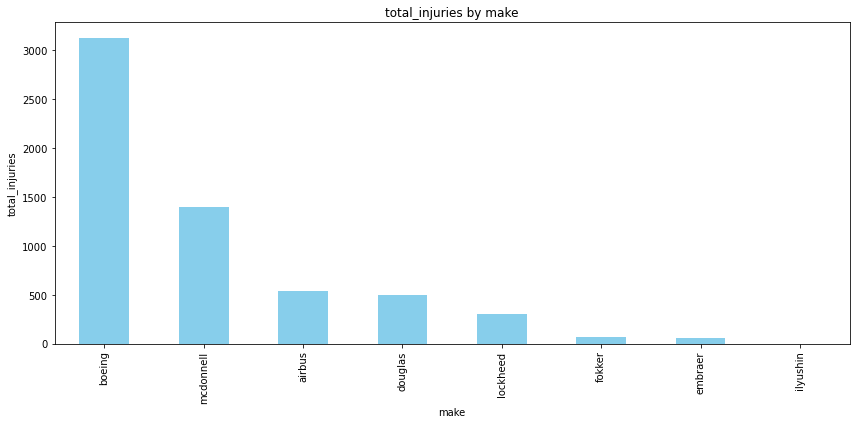

In [72]:
# Filter 'amateur_built' planes so we only see non-amateur or unknown planes
create_comparison_bar_chart(commercial_flights_df, 'make', 'total_injuries', 'sum', False, 50)

**Review**



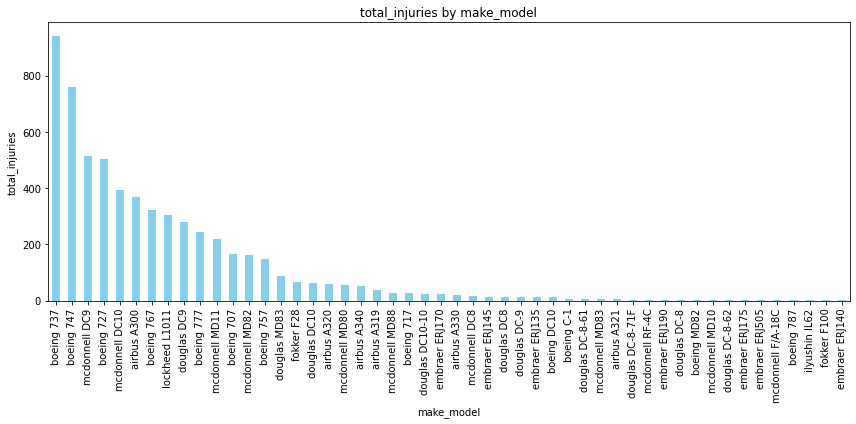

In [73]:
# Create a new column 'make_model' by combining 'make' and 'model' columns
create_comparison_bar_chart(commercial_flights_df, 'make_model', 'total_injuries', 'sum', False, 50)

## Which state has the most accidents?

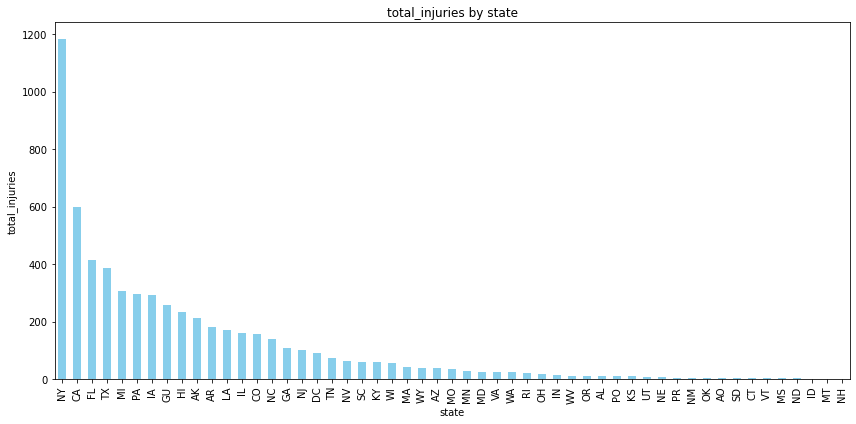

In [74]:
create_comparison_bar_chart(commercial_flights_df, 'state', 'total_injuries', 'sum', False, 100)

## Which weather pattern is most dangerous?

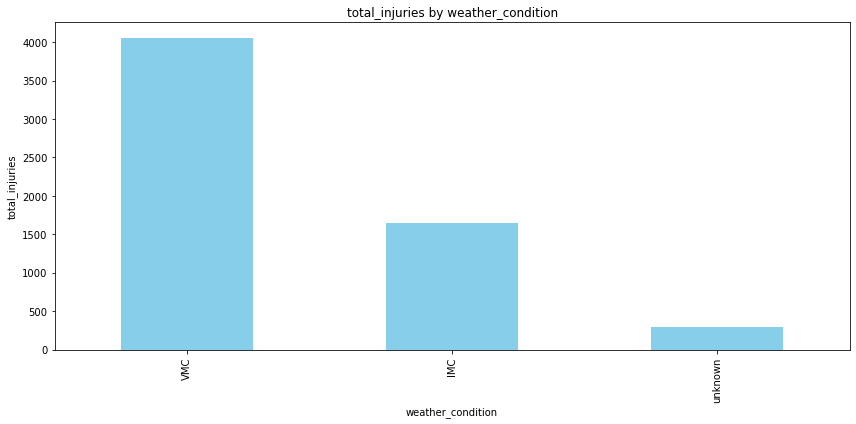

In [75]:
create_comparison_bar_chart(commercial_flights_df, 'weather_condition', 'total_injuries', 'sum', False, 10)

## Which phase of flight of most dangerous?

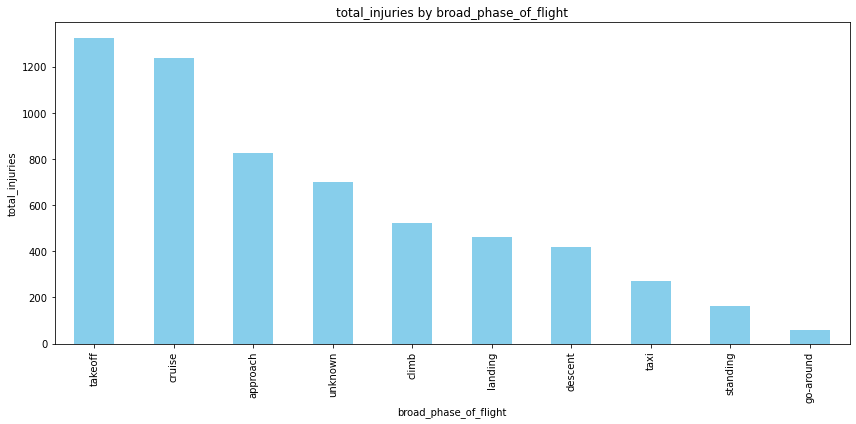

In [76]:
create_comparison_bar_chart(commercial_flights_df, 'broad_phase_of_flight', 'total_injuries', 'sum', False, 10)

## Which engine type is most dangerous?

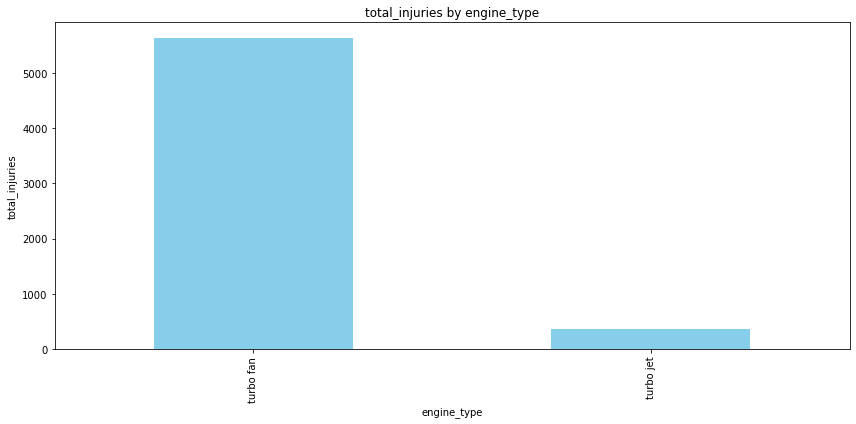

In [77]:
create_comparison_bar_chart(commercial_flights_df, 'engine_type', 'total_injuries', 'sum', False, 10)

## Do the number of engines the aircraft has mitigate the damage done to the aircraft?

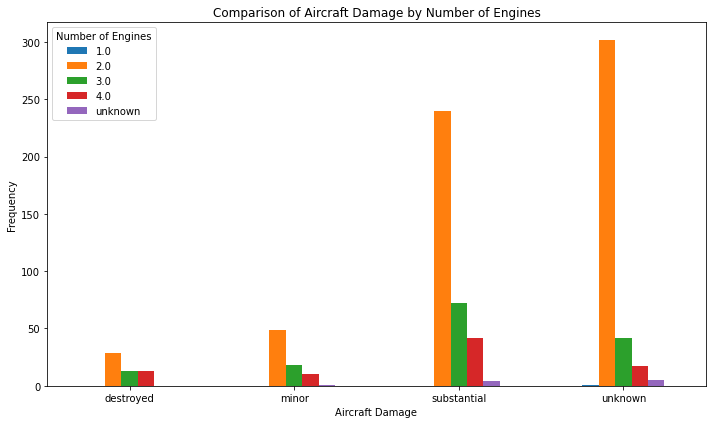

In [78]:
# Group the data by 'aircraft_damage' and 'number_of_engines' and count the frequency of each combination
grouped_data = commercial_flights_df.groupby(['aircraft_damage', 'number_of_engines']).size().unstack(fill_value=0)

# Plot the grouped bar chart
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Aircraft Damage by Number of Engines')
plt.xlabel('Aircraft Damage')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Number of Engines')
plt.tight_layout()
plt.show()

# Trend Analysis

## Number of Avaiation Accidents

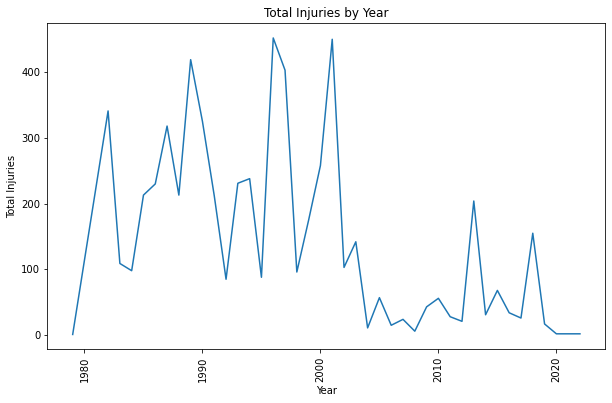

In [89]:
# Group the DataFrame to show pertinent values
yearly_injuries = commercial_flights_df.groupby('year')['total_injuries'].sum()

# Plot the results
yearly_injuries.plot(kind='line', figsize=(10, 6))
plt.title('Total Injuries by Year')
plt.xlabel('Year')
plt.ylabel('Total Injuries')
plt.xticks(rotation=90)
plt.show()

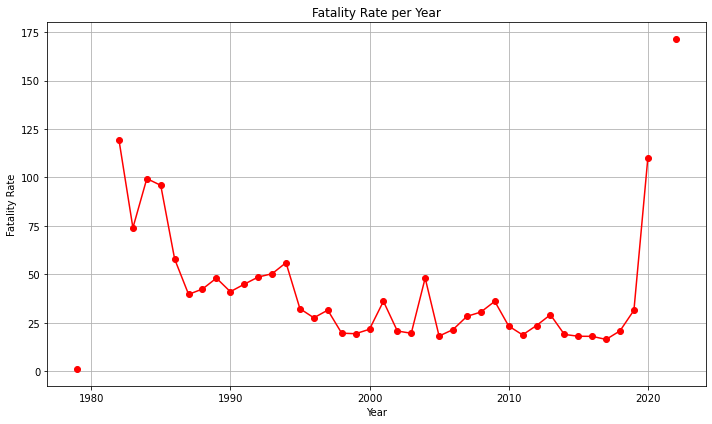

In [80]:
# Calculate the total number of accidents and fatal injuries per year
accidents_per_year = commercial_flights_df.groupby('year').size()
fatal_injuries_per_year = aviation_df.groupby('year')['total_fatal_injuries'].sum()

# Calculate the fatality rate per year
fatality_rate_per_year = fatal_injuries_per_year / accidents_per_year

# Plot the fatality rate over the years
plt.figure(figsize=(10, 6))
fatality_rate_per_year.plot(kind='line', color='red', marker='o')
plt.title('Fatality Rate per Year')
plt.xlabel('Year')
plt.ylabel('Fatality Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

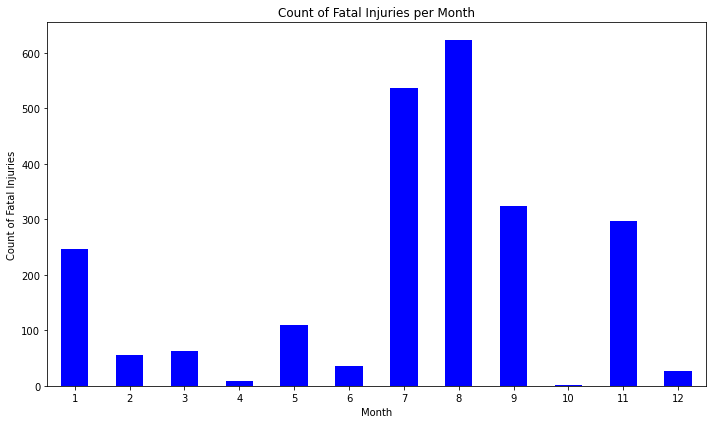

In [81]:
# Calculate the total number of fatal injuries per month
fatal_injuries_per_month = commercial_flights_df.groupby('month')['total_fatal_injuries'].sum()

# Plot the count of fatal injuries for each month
plt.figure(figsize=(10, 6))
fatal_injuries_per_month.plot(kind='bar', color='blue')
plt.title('Count of Fatal Injuries per Month')
plt.xlabel('Month')
plt.ylabel('Count of Fatal Injuries')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Commerical Aircraft

### Do certain commerical aircraft perform better in different weather conditions?

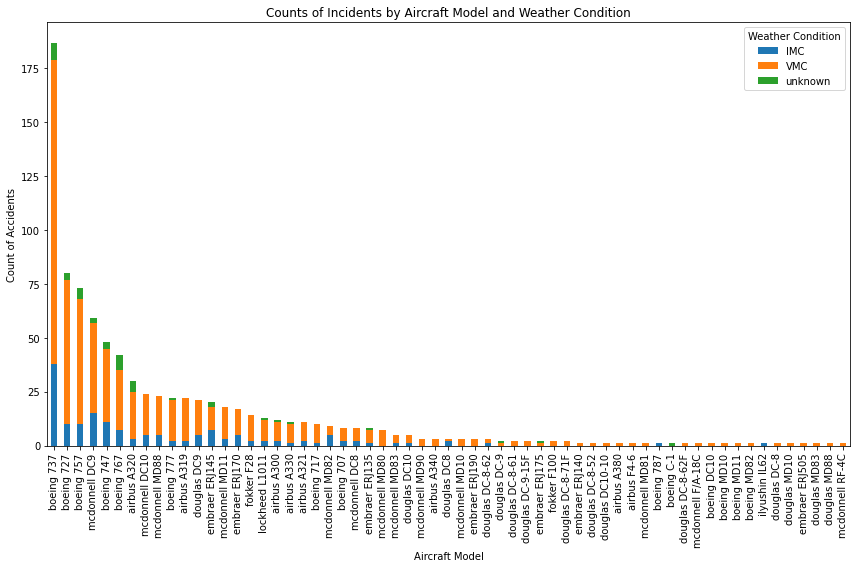

In [88]:
# Group the data by 'make_model' and 'weather_condition', count values, convert to single index DataFrame
weather_counts = commercial_flights_df.groupby(['make_model', 'weather_condition']).size().unstack()

# Sum the counts of the columns ('make_model' by 'weather_condition')
weather_counts_total = weather_counts.sum(axis=1)

# Sort the total counts in descending order
weather_counts_total_sorted = weather_counts_total.sort_values(ascending=False)

# Sorts the weather_counts df by using the indexes of the series weather_counts_total_sorted 
weather_counts_sorted = weather_counts.loc[weather_counts_total_sorted.index]

# Plotting
weather_counts_sorted.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Counts of Incidents by Aircraft Model and Weather Condition')
plt.xlabel('Aircraft Model')
plt.ylabel('Count of Accidents')
plt.xticks(rotation=90)
plt.legend(title='Weather Condition')
plt.tight_layout()
plt.show();

**Review**

- VMC
    - "...is an aviation flight category in which visual flight rules (VFR) flight is permitted—that is, conditions in which pilots have sufficient visibility to fly the aircraft maintaining visual separation from terrain and other aircraft. They are the opposite of instrument meteorological conditions (IMC)."
    - https://en.wikipedia.org/wiki/Visual_meteorological_conditions
        
- IMC
     - "...are weather conditions that require pilots to fly primarily by reference to flight instruments, and therefore under instrument flight rules (IFR), as opposed to flying by outside visual references under visual flight rules (VFR). Typically, this means flying in cloud or poor weather, where little or nothing can be seen or recognised when looking out of the window."
     - https://en.wikipedia.org/wiki/Instrument_meteorological_conditions

The data here shows that the majority of accidents occurred while there was sufficient visibility to fly the aircraft. It is worth looking into the data further to see if there is a way to determine if human error could have resulted in an accident in either IMC or VMC weather conditions. 

### Are certain commerical aircraft more susceptible to human error? 

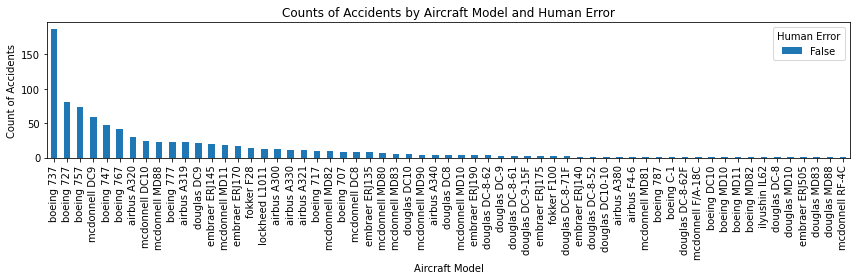

In [87]:
# Group the data by 'make_model' and 'human_error', count values, convert to single index DataFrame
human_error_counts = commercial_flights_df.groupby(['make_model', 'human_error']).size().unstack()

# Sum the counts of the columns ('make_model' by 'human_error')
human_error_counts_total = human_error_counts.sum(axis=1)

# Sort the total counts in descending order
human_error_counts_total_sorted = human_error_counts_total.sort_values(ascending=False)

# Sorts the human_error_counts df by using the indexes of the series human_error_counts_total_sorted 
human_error_counts_sorted = human_error_counts.loc[human_error_counts_total_sorted.index]

# Plotting
human_error_counts_sorted.plot(kind='bar', stacked=True, figsize=(12, 4))
plt.title('Counts of Accidents by Aircraft Model and Human Error')
plt.xlabel('Aircraft Model')
plt.ylabel('Count of Accidents')
plt.xticks(rotation=90)
plt.legend(title='Human Error')
plt.tight_layout()
plt.show();

**Review**

Fortunately, there are no accidents in commercial aircrafts that were explicitly the result of human error. It is worth noting that the 'report_staus' column did have ~7% missing values so there is the chance that an accident was the result of human error. 

Regardless of the weather condition (IMC v VMC), pilots of commercial aircrafts are not the root cause of the accident. 

For our stakeholder, this is good news as it allows a direct comparison of commercial aircraft as the accidents should all be caused by the aircraft itself and not the crew piloting the aircraft. 

### Are certain commerical aircraft more durable than others?

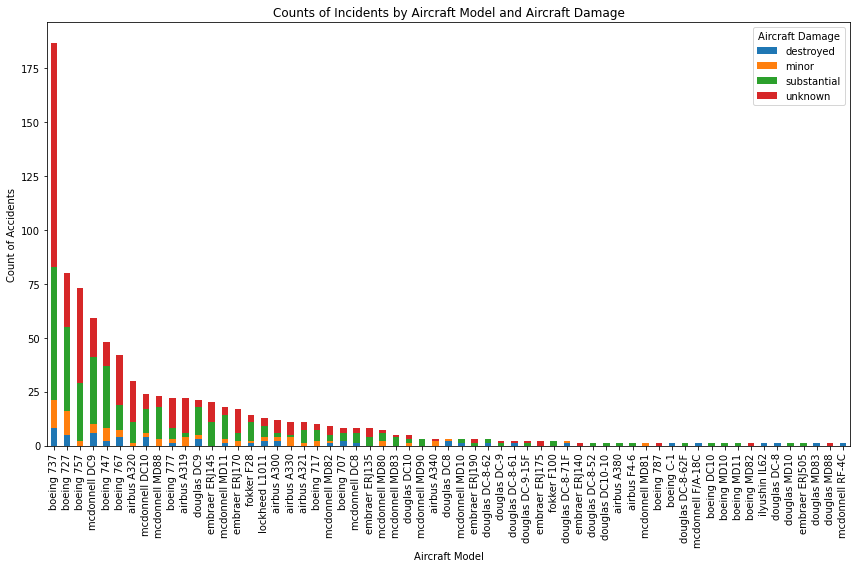

In [86]:
# Group the data by 'make_model' and 'aircraft_damage', count values, convert to single index DataFrame
damage_counts = commercial_flights_df.groupby(['make_model', 'aircraft_damage']).size().unstack()

# Sum the counts of the columns ('make_model' by 'weather_condition')
damage_counts_total = damage_counts.sum(axis=1)

# Sort the total counts in descending order
damage_counts_total_sorted = damage_counts_total.sort_values(ascending=False)

# Sorts the weather_counts df by using the indexes of the series weather_counts_total_sorted 
damage_counts_sorted = damage_counts.loc[damage_counts_total_sorted.index]

# Plotting
damage_counts_sorted.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Counts of Incidents by Aircraft Model and Aircraft Damage')
plt.xlabel('Aircraft Model')
plt.ylabel('Count of Accidents')
plt.xticks(rotation=90)
plt.legend(title='Aircraft Damage')
plt.tight_layout()
plt.show();

**Review**

While there are lot of unknown values, one thing is clear. When commercial aircraft get into accidents, they are rarely destroyed. Most of the time the damage is substantial but not beyond repair. 

### What is the safest commerical aircraft?

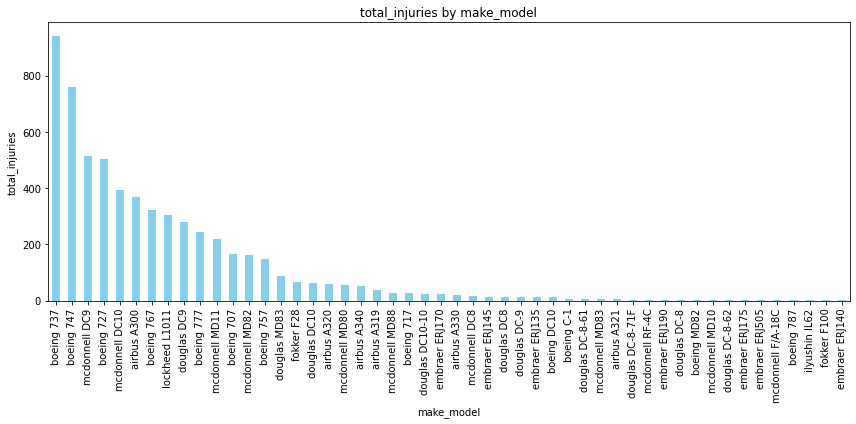

In [85]:
create_comparison_bar_chart(commercial_flights_df, 'make_model', 'total_injuries', 'sum', False, 50)

# Document Your Finding

## Conclusion:

Based on our findings we have concluded that these are the 3 top choices for your commerical airline company:

1. **Boeing 787**
- Pros:
    - Advanced technology and fuel efficiency (8,463 miles).
    - High passenger comfort with modern amenities.
    - No fatalities or hull losses reported.

- Cons:
    - Early operational issues with lithium-ion batteries.
    - Significant quality control issues and production slowdowns.

Verdict: Despite initial issues, the Boeing 787 is a reliable and modern aircraft suitable for long-haul flights, with a strong safety record post-battery redesign.

2. **Airbus A321**

- Pros:
    - Common type rating with other A320-family variants, reducing pilot training costs.
    - Still in production, ensuring parts availability and support.
    - Suitable for short to medium-haul routes (~4,000 miles).

- Cons:
    - Limited range operations, designed for short to medium flights.

Verdict: The Airbus A321 is a versatile, cost-effective option for medium-haul routes, benefiting from commonality with other A320-family aircraft.

3. **Airbus A330**

- Pros:
    - Extensive service history with more than 65 million flight hours.
    - Still in production, ensuring continued support and parts availability.
    - Well-suited for long flying ranges (~8,300 miles)

- Cons:
    - Less fuel efficient, which can result in high operational costs.
    - Older model plane, less advanced technology and lower overall efficiency.
    - Poor engine performance, which can decrease fuel efficiency and cause cabin vibrations.

Verdict: The Airbus A330 is a proven, reliable aircraft for medium to long-haul routes with a strong operational track record.